<a href="https://colab.research.google.com/github/amyfthau/CFGSum23D1G4/blob/data_modelling/Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount drive, change directory etc


In [1]:
# Import relevant libraries to mount drive
from google.colab import drive
import os
# Mount google drive
drive.mount('/content/drive')

# Define the path to your specific folder
specific_folder_path = '/content/drive/MyDrive/CFGdegree_Sum23_D1_G4'

# Navigate to the specific folder
os.chdir(specific_folder_path)

# Change directory to shared group folder
%cd /content/drive/MyDrive/CFGdegree_Sum23_D1_G4




Mounted at /content/drive
/content


# Import Relevant Libraries

In [48]:
# Import necessary libraries
import pandas as pd  # For data manipulation and analysis
import requests  # For making HTTP requests
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For data visualization
# from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller  # For performing Augmented Dickey-Fuller test
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  # For autocorrelation and partial autocorrelation plots
from matplotlib.pylab import rcParams  # For setting plot parameters
from datetime import datetime  # For working with date and time data
from statsmodels.tsa.exponential_smoothing.ets import ETSModel  # For Exponential Smoothing (ETS) model
from statsmodels.tsa.arima_model import ARIMA  # For Autoregressive Integrated Moving Average (ARIMA) model
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm  # For advanced statistical models and tests
from statsmodels.graphics.tsaplots import plot_acf  # For autocorrelation plot
from statsmodels.graphics.tsaplots import plot_pacf  # For partial autocorrelation plot
from sklearn import preprocessing  # For data preprocessing tasks
from sklearn.model_selection import train_test_split  # For splitting data into training and testing sets
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


# Functions

In [3]:
# Conduct Dickey-Fuller Test
#Ho: It is non stationary
#H1: It is stationary


def adfuller_test(data, column_name):
    """
    Conducts the Dickey-Fuller test to check for stationarity of a time series.

    Args:
        data (pandas.Series): The time series data to be tested.
        column_name (str): The name of the column being tested.

    Returns:
        None
    """
    result = adfuller(data)
    labels = ['ADF Test Statistic', 'p-value', 'Lags Used in The Test', 'Number of Observations Used']

    print(f"Results for column: {column_name}")

    for value, label in zip(result, labels):
        print(label + ': ' + str(value))

    if result[1] <= 0.05:
        print("P value is less than 0.05, so we can reject the null hypothesis (Ho). The series is stationary.")
        print("***********************\n")
    else:
        print("Weak evidence against null hypothesis. The series has a unit root and is not stationary.")
        print("***********************\n")


# Function to plot ACF and PACF
# Function to plot ACF and PACF
def plot_acf_pacf(data_series, max_lags=24):
    """
    Plot Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF).

    Args:
        data_series (pandas.Series): The time series data.
        max_lags (int): Maximum number of lags to show in the plots.

    Returns:
        None
    """
    rcParams['figure.figsize'] = (10, 6)

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))

    # Plot Autocorrelation Function (ACF)
    plot_acf(data_series, lags=max_lags, ax=ax1)
    ax1.set_xlim(0, max_lags)
    ax1.set_xlabel("Lags", fontsize=12)
    ax1.set_ylabel("ACF", fontsize=12)
    ax1.set_title("Autocorrelation Function (ACF)", fontsize=14)

    # Plot Partial Autocorrelation Function (PACF)
    plot_pacf(data_series, lags=max_lags, ax=ax2)
    ax2.set_xlim(0, max_lags)
    ax2.set_ylim(-1, 1)
    ax2.set_xlabel("Lags", fontsize=12)
    ax2.set_ylabel("PACF", fontsize=12)
    ax2.set_title("Partial Autocorrelation Function (PACF)", fontsize=14)

    plt.tight_layout()
    plt.show()



# Import relevant data

In [4]:
# Specify the file path for the UK House Price Index (UKHPI) data
data_path = '/content/drive/MyDrive/CFGdegree_Sum23_D1_G4/Data_Collection/Predicting_House_Prices/'
UKHPI2022_endpoint = 'UK-HPI-full-file-2022-01.csv'
uk_weighted_avg_df_endpoint = 'uk_weighted_avg_per_datecleaned.csv'

# Read the UKHPI data into a DataFrame
UKHPI2022_df = pd.read_csv(data_path + UKHPI2022_endpoint)
uk_weighted_avg_df = pd.read_csv(data_path + uk_weighted_avg_df_endpoint)

# Display the contents of the DataFrames
print(UKHPI2022_df.head())
print(uk_weighted_avg_df.head())


         Date     RegionName   AreaCode  AveragePrice      Index  IndexSA  \
0  01/01/2004  Aberdeenshire  S12000034   81693.66964  40.864214      NaN   
1  01/02/2004  Aberdeenshire  S12000034   81678.76231  40.856757      NaN   
2  01/03/2004  Aberdeenshire  S12000034   83525.09702  41.780317      NaN   
3  01/04/2004  Aberdeenshire  S12000034   84333.67900  42.184780      NaN   
4  01/05/2004  Aberdeenshire  S12000034   86379.95396  43.208353      NaN   

   1m%Change  12m%Change  AveragePriceSA  SalesVolume  ...     NewPrice  \
0        NaN         NaN             NaN        388.0  ...  88436.13953   
1  -0.018248         NaN             NaN        326.0  ...  88606.44649   
2   2.260483         NaN             NaN        453.0  ...  90296.91375   
3   0.968071         NaN             NaN        571.0  ...  90319.87844   
4   2.426403         NaN             NaN        502.0  ...  91989.17763   

    NewIndex  New1m%Change  New12m%Change  NewSalesVolume     OldPrice  \
0  40.267250

## Functions

In [5]:
# Function to filter data for a specific region
def filter_region_data(data_frame, region_name):
    """
    Filter the data for a specific region.

    Args:
        data_frame (pandas.DataFrame): The DataFrame containing the UKHPI data.
        region_name (str): The name of the region to filter.

    Returns:
        pandas.DataFrame: The filtered data for the specified region.
    """
    return data_frame[data_frame['RegionName'] == region_name]

# Function to plot a specified column for a region
def plot_column_into_line_graph(data_frame, region_name, column_name):
    """
    Plot a specified column for a region.

    Args:
        data_frame (pandas.DataFrame): The DataFrame containing the UKHPI data.
        region_name (str): The name of the region to plot.
        column_name (str): The name of the column to plot.

    Returns:
        None
    """
    region_data = filter_region_data(data_frame, region_name)

    region_data.plot(x='Date', y=column_name, marker='o', markersize = '2', linewidth='2')

    plt.xlabel("Date", fontsize=15)
    # Rotate the tick labels vertically
    plt.xticks(rotation=45)
    plt.ylabel(column_name, fontsize=15)
    plt.title(f"{column_name} per Month for {region_name}", fontsize=16)

    plt.show()

Plot average prices for "Ashford" first

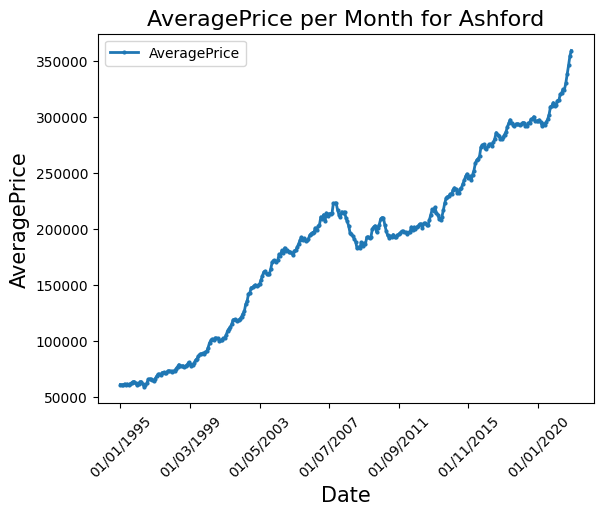

In [6]:
# Specify the column name to plot
column_to_plot = 'AveragePrice'
# Call the function to plot the specified column data for the 'Ashford' region
plot_column_into_line_graph(UKHPI2022_df, 'Ashford', column_to_plot)


Plot change in house prices - month change

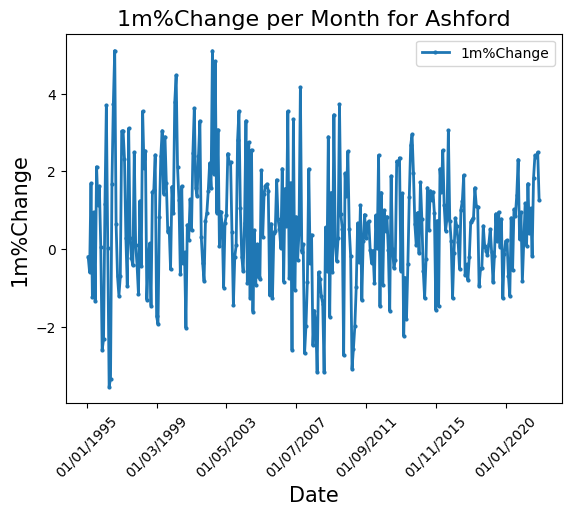

In [7]:
# Specify the column name to plot
column_to_plot = '1m%Change'
# Call the function to plot the specified column data for the 'Ashford' region
plot_column_into_line_graph(UKHPI2022_df, 'Ashford', column_to_plot)

In [ ]:
# Create series

# Set the start and end dates for the index
start_date = "1995-01-01"
end_date = "2022-01-01"

# Create a date range for the index
index = pd.date_range(start_date, end_date, freq="M")

# Create a Series with the forecasting variable and the custom index
monthly_p_change_Ashford = pd.Series(UKHPI2022_df[UKHPI2022_df['RegionName'] == 'Ashford']['1m%Change'].dropna().values, index=index)
"""
 This series represents the monthly percentage change in the housing price index for the region of Ashford.
 Each entry in this series represents the percentage change in the housing price index compared to the previous month. The values fluctuate over time,
 indicating that the rate of change in housing prices is not constant and varies from month to month.
 The overall pattern suggests that there have been periods of both positive and negative changes in housing prices in the Ashford region.
"""



# Create a Series with actual values - needed to convert rates of change back to levels
monthly_avg_p_Ashford = pd.Series(UKHPI2022_df[UKHPI2022_df['RegionName'] == 'Ashford']['AveragePrice'].dropna().values).iloc[1:]
monthly_avg_p_Ashford.index = index
"""
This series represents the actual average housing prices for the region of Ashford.
Each entry in this series represents the average housing price for a specific month. The values generally show an increasing trend over time,
 which suggests that the housing prices in the Ashford region have been increasing on average. The overall pattern indicates long-term appreciation
 in housing prices, with fluctuations and variations over the years.
"""


print(monthly_p_change_Ashford, monthly_avg_p_Ashford)


1995-01-31   -0.200227
1995-02-28   -0.596663
1995-03-31    1.689811
1995-04-30   -1.232108
1995-05-31    0.951496
                ...   
2021-08-31    1.819840
2021-09-30    2.411058
2021-10-31    2.378589
2021-11-30    2.494619
2021-12-31    1.275467
Freq: M, Length: 324, dtype: float64 1995-01-31     61216.13694
1995-02-28     60850.88266
1995-03-31     61879.14767
1995-04-30     61116.72955
1995-05-31     61698.25293
                  ...     
2021-08-31    330220.45570
2021-09-30    338182.26280
2021-10-31    346226.23040
2021-11-30    354863.25420
2021-12-31    359389.41810
Freq: M, Length: 324, dtype: float64


# Start modelling

# Import Variables

In [9]:
# Read the CSV file into a DataFrame and set 'Date' column as index
data_df = pd.read_csv('/content/drive/MyDrive/CFGdegree_Sum23_D1_G4/Data_Collection/Predicting_House_Prices/2023-08-23_merged_data_cleaned.csv', parse_dates=['Date'], index_col='Date')
data_df.head(100)

# Create a DataFrame to store original levels
original_levels_df = data_df.copy()

# Display summary information about the DataFrame
data_df.info()
# Check for NaN values and count them for each column
nan_counts = data_df.isna().sum()
# Print the NaN counts
print(nan_counts)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 133 entries, 2010-01-01 to 2021-01-01
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   AvgPriceUK_monthly  133 non-null    float64
 1   IntRate_monthly     133 non-null    float64
 2   CPIH_monthly        133 non-null    float64
 3   URate_monthly       133 non-null    float64
 4   ConsOutput_monthly  133 non-null    int64  
 5   Population_monthly  133 non-null    float64
 6   GDP_monthly         133 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 8.3 KB
AvgPriceUK_monthly    0
IntRate_monthly       0
CPIH_monthly          0
URate_monthly         0
ConsOutput_monthly    0
Population_monthly    0
GDP_monthly           0
dtype: int64


# Make stationary data

In [10]:
nonstationary_variables = ["AvgPriceUK_monthly","CPIH_monthly", "ConsOutput_monthly","Population_monthly", "GDP_monthly"]

# Loop through the variables and calculate the growth rates
for variable in nonstationary_variables:
    data_df[variable + "_growth"] = data_df[variable].pct_change() * 100

# Drop rows with NaN values in any of the columns
data_df.dropna(inplace=True)
# Print the DataFrame
print(data_df)
data_df.head(100)

# Display summary information about the DataFrame
data_df.info()
# Check for NaN values and count them for each column
nan_counts = data_df.isna().sum()
# Print the NaN counts
print(nan_counts)
# Check for and replace inf and -inf values with NaN
data_df.replace([np.inf, -np.inf], np.nan, inplace=True)

            AvgPriceUK_monthly  IntRate_monthly  CPIH_monthly  URate_monthly  \
Date                                                                           
2010-02-01       177113.356687              0.5          89.0            8.0   
2010-03-01       176527.571509              0.5          89.4            8.0   
2010-04-01       177819.436745              0.5          89.9            7.9   
2010-05-01       178876.091169              0.5          90.1            7.9   
2010-06-01       180230.621649              0.5          90.2            7.8   
...                        ...              ...           ...            ...   
2020-09-01       251367.682804              0.1         109.2            5.1   
2020-10-01       251484.842313              0.1         109.2            5.1   
2020-11-01       254290.801464              0.1         109.1            5.2   
2020-12-01       258490.866031              0.1         109.4            5.1   
2021-01-01       261778.374214          

The data is already detrended because we're looking at growth rates so the data is stationary.

# Test for stationarity Function

Results for column: IntRate_monthly
ADF Test Statistic: -1.8324133198054844
p-value: 0.36449221622597533
Lags Used in The Test: 0
Number of Observations Used: 131
Weak evidence against null hypothesis. The series has a unit root and is not stationary.
***********************

Results for column: CPIH_monthly
ADF Test Statistic: -0.6484036507265897
p-value: 0.8596655110762415
Lags Used in The Test: 12
Number of Observations Used: 119
Weak evidence against null hypothesis. The series has a unit root and is not stationary.
***********************

Results for column: URate_monthly
ADF Test Statistic: -1.1274616728811973
p-value: 0.7039972075525565
Lags Used in The Test: 2
Number of Observations Used: 129
Weak evidence against null hypothesis. The series has a unit root and is not stationary.
***********************

Results for column: ConsOutput_monthly
ADF Test Statistic: -1.3005321662960478
p-value: 0.6289288117961958
Lags Used in The Test: 12
Number of Observations Used: 119
Weak evid

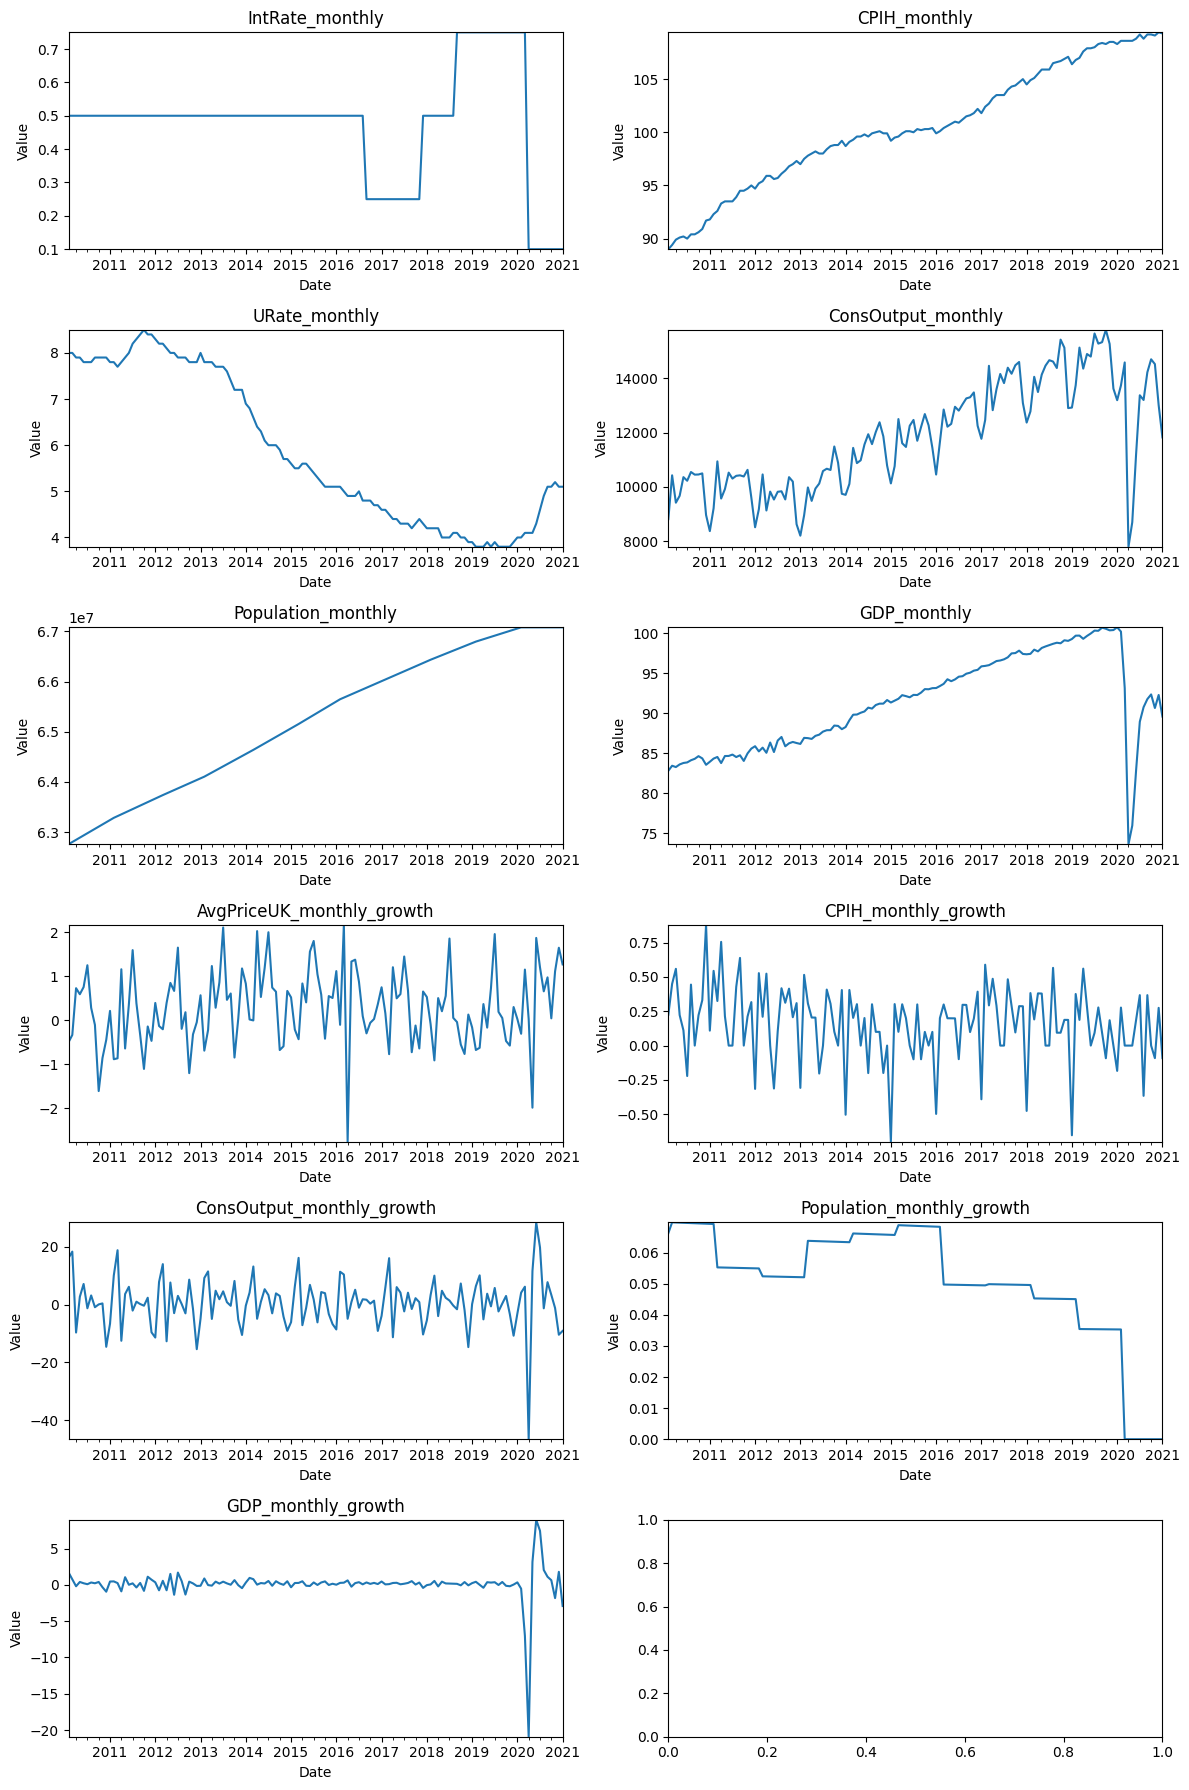

In [11]:
# Create a 6x2 grid of subplots
fig, axes = plt.subplots(6, 2, figsize=(12, 18))
fig.subplots_adjust(hspace=0.5)

# Apply the adfuller_test function and plot for each variable
for idx, variable in enumerate(data_df.columns[1:]):  # Skip 'Date' column
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]

    adfuller_test(data_df[variable], variable)

    # Plot the data
    data_df[variable].plot(ax=ax)
    ax.set_title(variable)
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')
    ax.set_ylim(np.nanmin(data_df[variable]), np.nanmax(data_df[variable]))  # Adjust y-axis limits

plt.tight_layout()
plt.show()

In [ ]:
# # if time series is not stationary-

# def differencing_series(df):
#   axes = plt.subplots(3, 2)
# # Original Series
#   axes[0, 0].plot(df.value)
#   axes[0, 0].set_title('Original Series')
#   plot_acf(df.value, ax=axes[0, 1])

# # 1st Differencing
#   axes[1, 0].plot(df.value.diff())
#   axes[1, 0].set_title('1st Order Diff')
#   plot_acf(df.value.diff().dropna(), ax=axes[1, 1])

# # 2nd Differencing
#   axes[2, 0].plot(df.value.diff().diff())
#   axes[2, 0].set_title('2nd Order Diff')
#   plot_acf(df.value.diff().diff().dropna(), ax=axes[2, 1])

#   plt.show()

# # pick a plot which shows stationarity (there is basically no clear pattern shown in the plot)

# Check parameters eg ACF, PACF

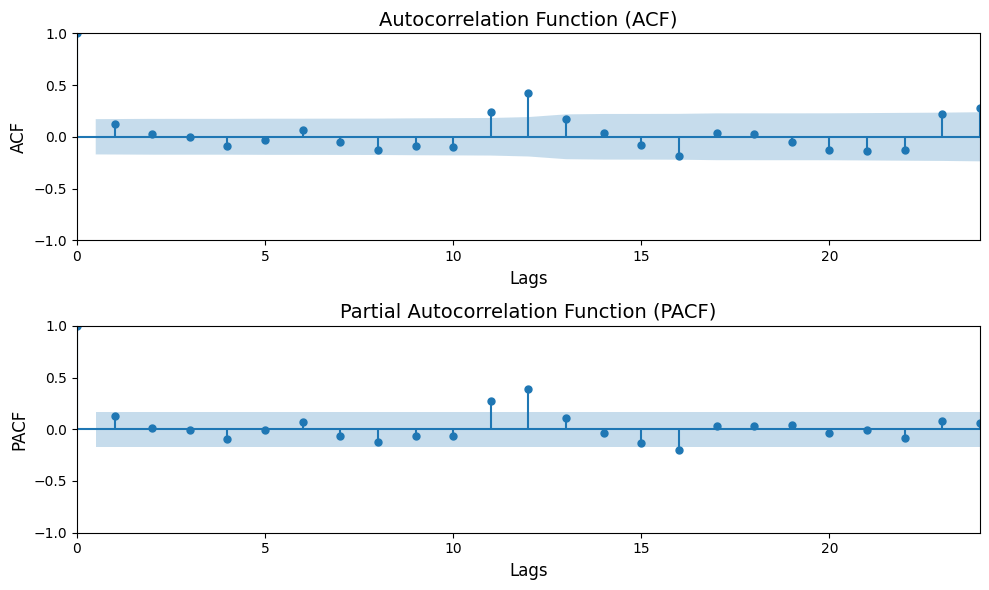

In [12]:
# Call the plot_acf_pacf function for AvgPriceUK_monthly_growth column
plot_acf_pacf(data_df['AvgPriceUK_monthly_growth'])

Autoregressive (AR) Component (p):
Look at the PACF plot. The lag at which the PACF cuts off or becomes close to zero can suggest the value of p. If the PACF cuts off after lag k, then you might consider an AR(p) term in your model.
Moving Average (MA) Component (q):
Look at the ACF plot. The lag at which the ACF cuts off or becomes close to zero can suggest the value of q. If the ACF cuts off after lag k, then you might consider an MA(q) term in your model.


1. The positive autocorrelation at the first and second lags (lags 1 and 2) around 0.25 suggests that there is a moderate positive correlation between the current observation and observations at these lags. This might indicate a recurring pattern every 1 or 2 periods.
The negative autocorrelation at the third lag (lag 3) around -0.25 indicates that there is a moderate negative correlation between the current observation and the observation three periods ago. This could suggest an alternating pattern The positive partial autocorrelation at the first lag suggests a strong direct relationship between the current observation and the observation at the first lag. This is typical of an autoregressive (AR) component in a time series model.The positive partial autocorrelation at the second lag indicates that there is still some correlation between the current observation and the observation two periods ago, even after accounting for the first lag. This could also be indicative of an AR component. The negative partial autocorrelation at the third lag suggests that there is a negative relationship between the current observation and the observation three periods ago, once the influence of the first two lags has been removed. This pattern may suggest a seasonal or moving average (MA) component.



2. Peaks and troughs of the ACF curve that alternate in a regular pattern suggest the presence of seasonality.
It's important to consider seasonality when modeling time series data, as it can impact the choice of forecasting models and the interpretation of results. Seasonal patterns may need to be addressed through techniques such as seasonal decomposition, differencing, or incorporating seasonal terms in forecasting models like Seasonal Autoregressive Integrated Moving Average (SARIMA) or Seasonal Exponential Smoothing (ETS).


Correlation being significant around 12 lags (1 year) and the presence of sine waves every 6 months indicate that your time series data might have a seasonal pattern with a yearly cycle.

If you observe significant autocorrelation at lag 12 and sinusoidal patterns every 6 months, this suggests that your time series data could be seasonal with a yearly cycle. You might want to consider applying seasonal decomposition techniques or using seasonal models like SARIMA (Seasonal Autoregressive Integrated Moving Average) to model and forecast this data.

Keep in mind that the interpretation of ACF and PACF plots can guide you in selecting appropriate time series models and making informed decisions about data transformations or model specifications.






# Modelling notes


Both SARIMA (Seasonal Autoregressive Integrated Moving Average) and ETS (Exponential Smoothing State Space Model) are time series forecasting methods that are commonly used to model and predict future values in time series data. However, they use different approaches and assumptions to achieve their predictions:

SARIMA (Seasonal ARIMA):

SARIMA is an extension of the ARIMA (Autoregressive Integrated Moving Average) model that includes seasonal components.
It is designed to capture both the autoregressive (AR) and moving average (MA) patterns in the data, as well as the seasonality present in the time series.
SARIMA models consider the order of differencing (d), autoregressive order (p), moving average order (q), seasonal differencing (D), seasonal autoregressive order (P), and seasonal moving average order (Q) as parameters.
It's well-suited for time series data with trends and seasonality.
ETS (Exponential Smoothing State Space Model):

ETS is based on the idea of exponential smoothing, which gives different weights to different observations in the past.
ETS models include three main components: error (E), trend (T), and seasonality (S).
ETS models can be classified into various types, such as ETS(AAA), ETS(AAd), ETS(MMM), etc., each with different assumptions about the presence and combination of error, trend, and seasonality.
ETS models are suitable for forecasting time series with various patterns, including trend, seasonality, and irregular fluctuations.
Key differences between SARIMA and ETS:

Model Structure:

SARIMA focuses on the autoregressive and moving average patterns, and it extends ARIMA to include seasonal components.
ETS is based on exponential smoothing and uses a combination of error, trend, and seasonality components.
Model Assumptions:

SARIMA assumes that the data has autoregressive and moving average patterns, and it captures these patterns through differencing and lagged terms.
ETS assumes that future observations are influenced by the error, trend, and seasonality in the past observations, and it assigns different weights to different historical observations.
Complexity:

SARIMA models can become complex as the number of parameters increases with the inclusion of seasonal components and lags.
ETS models are generally simpler in terms of parameter estimation and interpretation.
Application:

SARIMA is suitable for time series data with clear trends and seasonality, where the patterns are more linear.
ETS is more flexible and can handle various time series patterns, making it suitable for data with nonlinear trends, changing seasonality, and irregular fluctuations.
Both methods have their strengths and weaknesses, and the choice between SARIMA and ETS often depends on the nature of the time series data and the patterns you're trying to capture.

SARIMA might be more suitable if:

Seasonality and Trends: If your house price growth data shows clear seasonal patterns (e.g., prices tend to rise during certain months or quarters) and long-term trends (overall increasing or decreasing prices), SARIMA could be a good choice. It can capture both the seasonal patterns and the trend through its seasonal and autoregressive components.

Complex Patterns: If your data has complex interactions between lagged values, seasonality, and trends, SARIMA's ability to handle multiple autoregressive and moving average terms may be beneficial.

Stationarity: If your data is not stationary and requires differencing to achieve stationarity, SARIMA's differencing and integration components can help handle this.

ETS might be more suitable if:

Changing Patterns: If your house price growth data exhibits changing patterns over time, such as varying seasonality or trends, ETS might be a better fit. ETS models can adapt to changing patterns more flexibly.

Simplicity: If your data doesn't have highly complex patterns and you're looking for a simpler model, ETS could be a good choice due to its relatively straightforward structure.

Irregular Fluctuations: If your data contains irregular fluctuations that don't follow a specific autoregressive or moving average pattern, ETS models can capture these irregularities effectively.

Limited Historical Data: If you have limited historical data, ETS might be more suitable as it doesn't require as many historical observations as SARIMA, especially for models with high order parameters.

Interpretability: If you value model interpretability and ease of parameter interpretation, ETS models tend to have fewer parameters than SARIMA.

In practice, it's a good idea to try both SARIMA and ETS models and compare their performance. You can use techniques like cross-validation to evaluate the accuracy of their forecasts on a holdout dataset. Ultimately, the choice between the two methods depends on how well they capture the underlying patterns in your specific house price growth data.
LSTM (Long Short-Term Memory) is a type of recurrent neural network (RNN) that is well-suited for handling sequences of data like time series. ARIMA (AutoRegressive Integrated Moving Average) and ETS (Exponential Smoothing State Space Model) are classical time series forecasting methods, and Random Forest is a machine learning ensemble algorithm. Each of these methods has its own strengths and weaknesses, and the choice between them depends on various factors including the nature of your data and your forecasting goals. Here's a comparison of these methods:

LSTM:

Strengths:
Can capture complex temporal dependencies in data.
Can handle long sequences and non-linear relationships.
Able to model both trend and seasonality in the data.
Weaknesses:
Requires a large amount of data to train effectively.
Can be computationally expensive to train.
Prone to overfitting if not properly regularized.
ARIMA:

Strengths:
Well-suited for univariate time series data.
Can capture auto-regressive (AR) and moving average (MA) patterns.
Generally interpretable and intuitive to understand.
Weaknesses:
Assumes that the data is stationary, which might require pre-processing.
May not handle non-linear relationships well.
Doesn't handle external factors or multiple correlated variables easily.
ETS:

Strengths:
Good for capturing simple trend and seasonality patterns.
Can be more robust to outliers and irregular data.
Handles multiple seasonalities well (in ETS-M and ETS-M-Adaptive models).
Weaknesses:
May not perform well with complex and changing patterns.
Less flexible compared to other methods.
Interpretability can be limited, especially for more advanced ETS models.
Random Forest:

Strengths:
Can handle complex relationships between features.
Able to capture interactions between variables.
Generally robust to outliers and noise.
Weaknesses:
May not capture temporal dependencies well without additional preprocessing.
Doesn't handle seasonality and autocorrelation natively.
Hyperparameter tuning can be challenging.
In summary, the choice between LSTM, ARIMA, ETS, and Random Forest depends on your data characteristics, the complexity of patterns you want to capture, the amount of available data, and your computational resources. For time series forecasting, ARIMA and ETS are often used when the data exhibits clear trend and seasonality, while LSTM is suitable for capturing complex temporal dependencies. Random Forest can be a good choice when dealing with multiple features and interactions, but it might not capture time-related patterns as effectively as the other methods

# Model 1: SARIMA - univariate

## Forecast changes

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


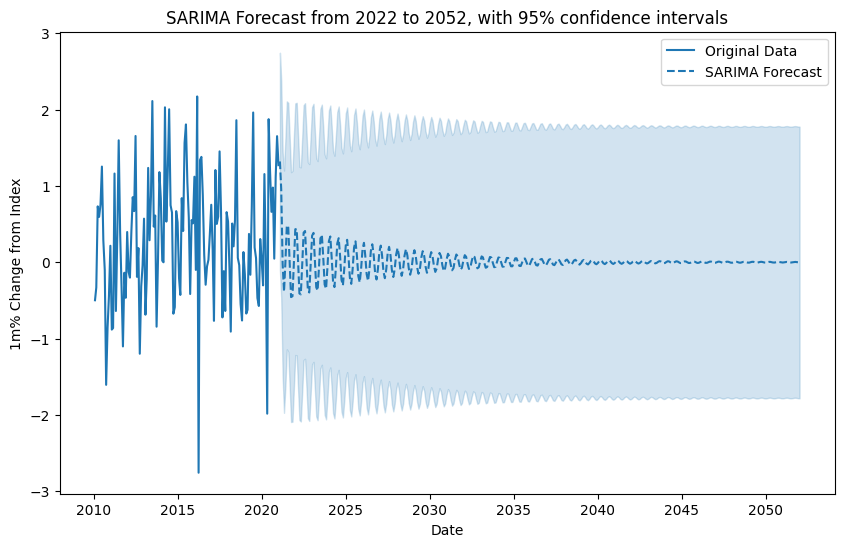

[ 1.32014964e+00  9.57622626e-01 -2.12529692e-02 -3.86308722e-01
  9.25415730e-03  4.82832764e-01  4.57714539e-01  1.68768243e-04
 -4.56899726e-01 -4.45870704e-01 -9.31186192e-03  4.32495820e-01
  4.33713218e-01  1.80306902e-02 -4.09419484e-01 -4.21405259e-01
 -2.62407335e-02  3.87524263e-01  4.09060666e-01  3.38974763e-02
 -3.66701267e-01 -3.96759447e-01 -4.09829327e-02  3.46867283e-01
  3.84558318e-01  4.74965346e-02 -3.27956720e-01 -3.72497873e-01
 -5.34489762e-02  3.09916147e-01  3.60607462e-01  5.88580627e-02
 -2.92700597e-01 -3.48908520e-01 -6.37459154e-02  2.76271055e-01
  3.37416845e-01  6.81370970e-02 -2.60592761e-01 -3.26144162e-01
 -7.20573603e-02  2.45634055e-01  3.15099193e-01  7.55328176e-02
 -2.31365596e-01 -3.04288414e-01 -7.85893957e-02  2.17759830e-01
  2.93716566e-01  8.12524841e-02 -2.04790627e-01 -2.83387036e-01
 -8.35467129e-02  1.92433034e-01  2.73302112e-01  8.54958186e-02
 -1.80663106e-01 -2.63463181e-01 -8.71225689e-02  1.69457788e-01
  2.53870874e-01  8.84487

In [27]:
# Choose the column to model
column_name = 'AvgPriceUK_monthly_growth'
data_series = data_df[column_name]

# SARIMA Parameters
p = 3
d = 0
q = 7
P = 0
D = 0
Q = 0
s = 6

# Fit the SARIMA model
model = SARIMAX(data_series, order=(p, d, q), seasonal_order=(P, D, Q, s))
results = model.fit(maxiter=1000)

# Forecast future values
forecast_steps = 12 * (2052 - 2022 + 1)  # Number of steps to forecast
forecast = results.get_forecast(steps=forecast_steps)
confidence_intervals = forecast.conf_int()

# Plot the original data, forecast, and confidence intervals
plt.figure(figsize=(10, 6))
plt.plot(data_series.index, data_series.values, label='Original Data')
plt.plot(forecast.predicted_mean.index, forecast.predicted_mean.values, color='#1f77b4', linestyle='--', label='SARIMA Forecast')
plt.fill_between(forecast.predicted_mean.index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='#1f77b4', alpha=0.2)
plt.xlabel('Date')
plt.ylabel('1m% Change from Index')
plt.title('SARIMA Forecast from 2022 to 2052, with 95% confidence intervals')
plt.legend()
plt.show()

print(forecast.predicted_mean.values)

## Levels

In [ ]:
# Revert the monthly percentage change forecast back into levels (average house prices)
initial_price = original_levels_df['AvgPriceUK_monthly'].iloc[-1]  # Get the last available actual price as the initial price
forecasted_changes = forecast.predicted_mean.values  # Use the forecasted mean values

# Calculate the forecasted price levels
forecasted_prices = [initial_price]
for change in forecasted_changes:
    forecasted_price = forecasted_prices[-1] * (1 + change / 100)
    forecasted_prices.append(forecasted_price)



# Create a new Series with the forecasted price levels
forecasted_price_series = pd.Series(forecasted_prices[1:], index=data_df.index)  # Replace data_df with your index

# Plot the SARIMA forecast in price levels
plt.figure(figsize=(10, 6))
plt.plot(original_levels_df.index, original_levels_df['AvgPriceUK_monthly'], label='Actual Data')
plt.plot(forecasted_price_series.index, forecasted_price_series, color='#1f77b4', linestyle='--', label='Forecast in Price Levels')

# Plot confidence intervals as shaded regions
plt.fill_between(forecasted_price_series.index,
                 forecasted_price_series * (1 + confidence_intervals.iloc[:, 0] / 100),
                 forecasted_price_series * (1 + confidence_intervals.iloc[:, 1] / 100),
                 color='#1f77b4', alpha=0.2)

# Plot the forecasted region with a light grey background
forecast_start = data_df.index[-1]  # Adjust this date to match your data
forecast_end = forecasted_price_series.index[-1]
plt.axvspan(forecast_start, forecast_end, color='lightgrey', alpha=0.5)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Average House Price')
plt.title('SARIMA Forecast from 2022 to 2052, in Price Levels')
plt.legend()
plt.show()


# # Revert the monthly percentage change forecast back into levels (average house prices)
# # Get the last available actual price as the initial price
# initial_price = monthly_avg_p_Ashford.iloc[-1]
# # Get the forecasted percentage change for the first period
# forecasted_change = SARIMA_forecast.predicted_mean.values[0]
# # Calculate the forecasted price level for the first period
# forecasted_price_levels = [initial_price * (1 + forecasted_change / 100)]

# # Calculate the forecasted values and confidence intervals for the rest of the period
# for change, lower_ci, upper_ci in zip(SARIMA_forecast.predicted_mean.values[1:], confidence_intervals['mean_ci_lower'].values[1:], confidence_intervals['mean_ci_upper'].values[1:]):
#     # Calculate the forecasted price level for each period based on the percentage change
#     forecasted_price = forecasted_price_levels[-1] * (1 + change / 100)
#     # Calculate the lower and upper bounds of the confidence interval in price levels
#     lower_price = forecasted_price * (1 + lower_ci / 100)
#     upper_price = forecasted_price * (1 + upper_ci / 100)
#     # Append the forecasted price level to the list
#     forecasted_price_levels.append(forecasted_price)

# # Create a new Series with the forecasted price levels
# forecasted_price_series = pd.Series(forecasted_price_levels, index=SARIMA_forecast.predicted_mean.index)

# # Plot the SARIMA forecast in price levels
# plt.figure(figsize=(10, 6))
# plt.plot(monthly_avg_p_Ashford.index, monthly_avg_p_Ashford.values, label='Actual Data')
# plt.plot(forecasted_price_series.index, forecasted_price_series.values, color='#1f77b4', linestyle='--', label='Forecast in Price Levels')

# # Plot confidence intervals as shaded regions
# plt.fill_between(forecasted_price_series.index,
#                  forecasted_price_series * (1 + confidence_intervals['mean_ci_lower'] / 100),
#                  forecasted_price_series * (1 + confidence_intervals['mean_ci_upper'] / 100),
#                  color='#1f77b4', alpha=0.2)

# # Plot the forecasted region with a light grey background
# forecast_start = pd.Timestamp('2022-01-31')
# forecast_end = forecasted_price_series.index[-1]
# plt.axvspan(forecast_start, forecast_end, color='lightgrey', alpha=0.5)

# # Add labels and title
# plt.xlabel('Date')
# plt.ylabel('Average House Price')
# plt.title('SARIMA Forecast from 2022 to 2052, in Price Levels')
# plt.legend()
# plt.show()


ValueError: ignored

## Model Evaluation

In [ ]:

# # Train-test split
# train_size = int(0.8 * len(data))
# train_data = data.iloc[:train_size]
# test_data = data.iloc[train_size:]

# Model 2: SARIMAX

## Model Evaluation

In [95]:
# # Choose the column to model
# column_name = 'AvgPriceUK_monthly_growth'
# data_series = data_df[column_name]

# # Exogenous variables for the entire forecasting period
# future_exog_data = data_df[['IntRate_monthly', 'CPIH_monthly_growth', 'ConsOutput_monthly_growth', 'Population_monthly_growth', 'GDP_monthly_growth']]

# # SARIMA Parameters
# p = 3
# d = 0
# q = 7
# P = 0
# D = 0
# Q = 0
# s = 6

# # Fit the SARIMA model with adjusted parameters and settings
# model = SARIMAX(data_series, exog=future_exog_data, order=(p, d, q), seasonal_order=(P, D, Q, s))
# results = model.fit(maxiter=1000)

# # Forecast future values
# forecast_steps = 360  # Number of steps to forecast (30 years)
# forecast = results.get_forecast(steps=forecast_steps, exog=future_exog_data[-forecast_steps:])

# # Confidence intervals
# confidence_intervals = forecast.conf_int()

# # Plot the original data, forecast, and confidence intervals
# plt.figure(figsize=(10, 6))
# plt.plot(data_series.index, data_series.values, label='Original Data')
# plt.plot(forecast.predicted_mean.index, forecast.predicted_mean.values, color='#1f77b4', linestyle='--', label='SARIMA Forecast')
# plt.fill_between(forecast.predicted_mean.index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='#1f77b4', alpha=0.2)
# plt.xlabel('Date')
# plt.ylabel('1m% Change from Index')
# plt.title('SARIMA Forecast from 2022 to 2052 with Exogenous Variables, 95% Confidence Intervals')
# plt.legend()
# plt.show()

# print(forecast.predicted_mean.values)

# Model 3: Exponential Smoothing (ETS)
Exponential Smoothing methods are suitable for capturing different patterns in the data such as trend and seasonality.

## Forecast changes

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


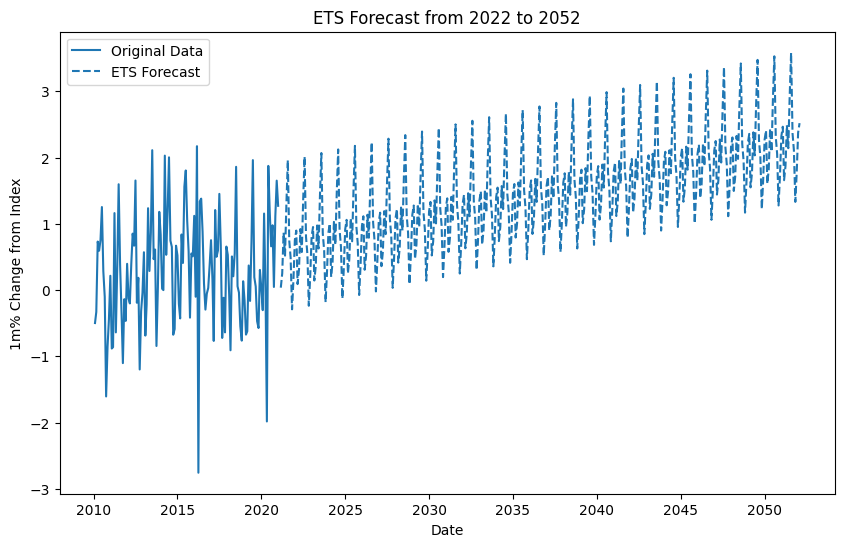

2021-02-01    0.035937
2021-03-01    0.251444
2021-04-01    0.866769
2021-05-01    0.519721
2021-06-01    1.303216
                ...   
2051-09-01    2.109379
2051-10-01    1.331111
2051-11-01    1.772107
2051-12-01    2.377312
2052-01-01    2.520048
Freq: MS, Name: simulation, Length: 372, dtype: float64


In [42]:
# Choose the column to model
column_name = 'AvgPriceUK_monthly_growth'
data_series = data_df[column_name]

# Fit the ETS model
model = ETSModel(data_series, error='add', trend='add', seasonal='add', seasonal_periods=12)
results = model.fit()

# Forecast future values
forecast_steps = 372  # Number of steps to forecast (2022 to 2052)
forecast_index = pd.date_range(start=data_series.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq='M')
forecast = results.forecast(steps=forecast_steps)

# Plot the original data and forecast
plt.figure(figsize=(10, 6))
plt.plot(data_series.index, data_series.values, label='Original Data')
plt.plot(forecast_index, forecast, color='#1f77b4', linestyle='--', label='ETS Forecast')
plt.xlabel('Date')
plt.ylabel('1m% Change from Index')
plt.title('ETS Forecast from 2022 to 2052')
plt.legend()
plt.show()

print(forecast)


## Levels

In [ ]:
## PLACEHOLDER ##

# Model Evaluation

In [ ]:
## PLACEHOLDER ##

# Model 4: LSTM

## Forecast changes

Epoch 1/50
4/4 [==============================] - 5s 14ms/step - loss: 0.4052
Epoch 2/50
4/4 [==============================] - 0s 15ms/step - loss: 0.2265
Epoch 3/50
4/4 [==============================] - 0s 13ms/step - loss: 0.1028
Epoch 4/50
4/4 [==============================] - 0s 16ms/step - loss: 0.0428
Epoch 5/50
4/4 [==============================] - 0s 13ms/step - loss: 0.0418
Epoch 6/50
4/4 [==============================] - 0s 15ms/step - loss: 0.0530
Epoch 7/50
4/4 [==============================] - 0s 19ms/step - loss: 0.0426
Epoch 8/50
4/4 [==============================] - 0s 15ms/step - loss: 0.0344
Epoch 9/50
4/4 [==============================] - 0s 14ms/step - loss: 0.0333
Epoch 10/50
4/4 [==============================] - 0s 13ms/step - loss: 0.0347
Epoch 11/50
4/4 [==============================] - 0s 12ms/step - loss: 0.0346
Epoch 12/50
4/4 [==============================] - 0s 17ms/step - loss: 0.0332
Epoch 13/50
4/4 [==============================] - 0s 13ms/st

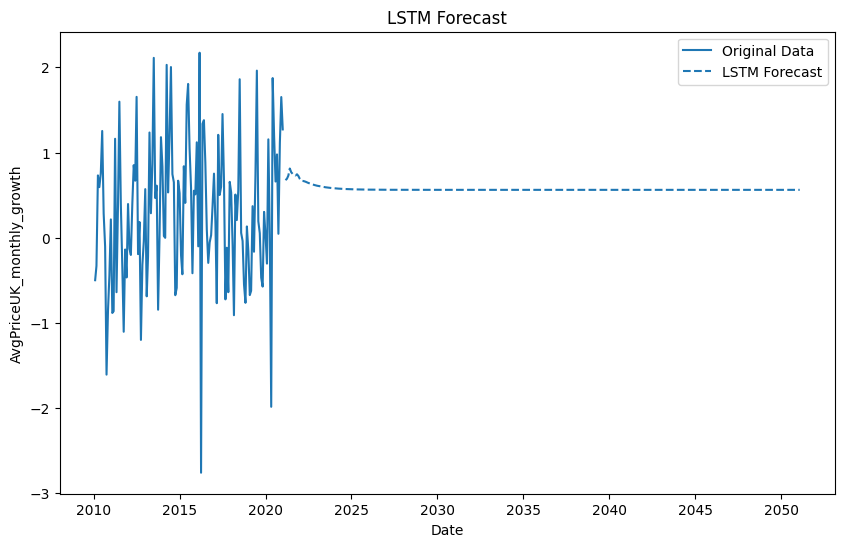

In [77]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.preprocessing import MinMaxScaler
# from keras.models import Sequential
# from keras.layers import LSTM, Dense


# # Choose the column to model
# column_name = 'AvgPriceUK_monthly_growth'
# data_series = data_df[column_name]

# # Normalize the data
# scaler = MinMaxScaler()
# data_scaled = scaler.fit_transform(data_series.values.reshape(-1, 1))

# # Create sequences for LSTM
# sequence_length = 12
# sequences = []
# for i in range(len(data_scaled) - sequence_length + 1):
#     sequences.append(data_scaled[i:i+sequence_length])

# sequences = np.array(sequences)

# # Split into training and forecasting data
# training_size = len(sequences)  # Use all available data for training
# train_data = sequences[:training_size]

# # Prepare training data
# X_train = train_data[:, :-1]
# y_train = train_data[:, -1]

# # Build and compile the model
# model = Sequential()
# model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(Dense(1))
# model.compile(optimizer='adam', loss='mean_squared_error')

# # Train the model
# model.fit(X_train, y_train, epochs=50, batch_size=32)

# # Generate initial input sequence for forecasting
# forecast_input = train_data[-1, 1:]  # Use the last sequence of training data

# # Forecast steps ahead
# forecast_steps = 12 * (2050 - 2021 + 1)  # Number of steps to forecast
# forecasted_values = []

# for _ in range(forecast_steps):
#     # Reshape forecast input to match model input shape
#     forecast_input_reshaped = forecast_input.reshape(1, forecast_input.shape[0], 1)

#     # Predict next value
#     next_value = model.predict(forecast_input_reshaped)
#     forecasted_values.append(next_value)

#     # Update forecast input for the next step
#     forecast_input = np.concatenate([forecast_input[1:], next_value], axis=0)

# # Convert the forecasted_values list to a numpy array
# forecasted_values = np.array(forecasted_values)

# # Rescale and inverse transform forecasted values
# print("Shape of forecasted_values before inverse transform:", forecasted_values.shape)
# forecasted_values = forecasted_values.reshape(-1, 1)
# forecasted_values = scaler.inverse_transform(forecasted_values)
# print("Shape of forecasted_values after inverse transform:", forecasted_values.shape)

# # Plot the original data and LSTM forecast
# plt.figure(figsize=(10, 6))
# plt.plot(data_series.index, data_series.values, label='Original Data')
# forecast_index = pd.date_range(start=data_series.index[-1], periods=forecast_steps+1, freq='M')[1:]
# plt.plot(forecast_index, forecasted_values, color='#1f77b4', linestyle='--', label='LSTM Forecast')
# plt.xlabel('Date')
# plt.ylabel('AvgPriceUK_monthly_growth')
# plt.title('LSTM Forecast')
# plt.legend()
# plt.show()


# # # Create sequences for LSTM
# # sequence_length = 12
# # sequences = []
# # for i in range(len(data_scaled) - sequence_length + 1):
# #     sequences.append(data_scaled[i:i+sequence_length])

# # sequences = np.array(sequences)

# # # Split into train and test sets
# # train_size = int(len(sequences) * 0.8)
# # train_data = sequences[:train_size]
# # test_data = sequences[train_size:]

# # # Print the shapes for debugging
# # print("Train data shape:", train_data.shape)
# # print("Test data shape:", test_data.shape)

# # # Split into input features and target variable
# # X_train = train_data[:, :-1]
# # y_train = train_data[:, -1]

# # # Print the shapes for debugging
# # print("X_train shape before reshaping:", X_train.shape)
# # print("y_train shape:", y_train.shape)

# # # Build and compile the model
# # model = Sequential()
# # model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
# # model.add(Dense(1))
# # model.compile(optimizer='adam', loss='mean_squared_error')

# # # Print the model summary for debugging
# # print(model.summary())

# # # Fit the model
# # model.fit(X_train, y_train, epochs=50, batch_size=32)
# # print("Model trained successfully!")


Epoch 1/50
4/4 [==============================] - 4s 21ms/step - loss: 0.2829
Epoch 2/50
4/4 [==============================] - 0s 24ms/step - loss: 0.1490
Epoch 3/50
4/4 [==============================] - 0s 22ms/step - loss: 0.0569
Epoch 4/50
4/4 [==============================] - 0s 23ms/step - loss: 0.0362
Epoch 5/50
4/4 [==============================] - 0s 23ms/step - loss: 0.0528
Epoch 6/50
4/4 [==============================] - 0s 27ms/step - loss: 0.0438
Epoch 7/50
4/4 [==============================] - 0s 22ms/step - loss: 0.0322
Epoch 8/50
4/4 [==============================] - 0s 20ms/step - loss: 0.0330
Epoch 9/50
4/4 [==============================] - 0s 20ms/step - loss: 0.0354
Epoch 10/50
4/4 [==============================] - 0s 26ms/step - loss: 0.0347
Epoch 11/50
4/4 [==============================] - 0s 28ms/step - loss: 0.0327
Epoch 12/50
4/4 [==============================] - 0s 27ms/step - loss: 0.0319
Epoch 13/50
4/4 [==============================] - 0s 23ms/st

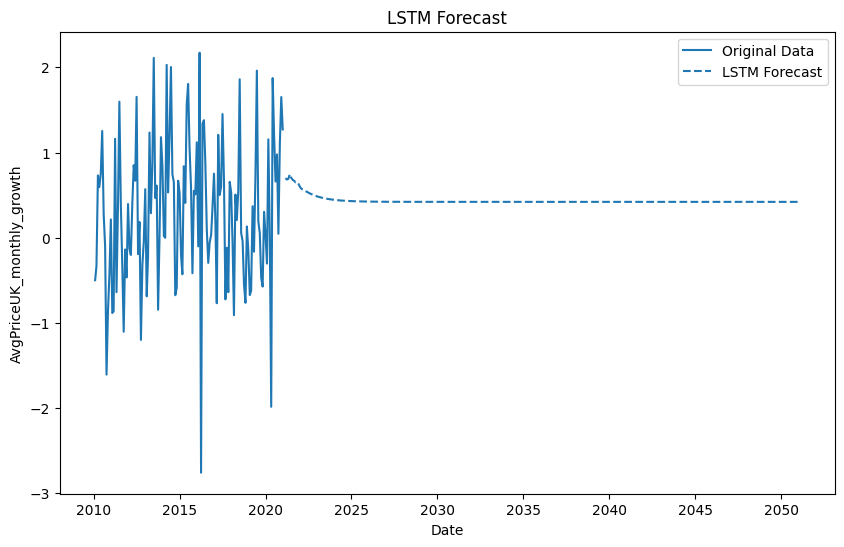

In [94]:
# Assume you have additional independent variables 'Variable1' and 'Variable2'
independent_variables = ['GDP_monthly_growth', 'IntRate_monthly']

# Normalize the additional independent variables
scaler_independent = MinMaxScaler()
data_independent_scaled = scaler_independent.fit_transform(data_df[independent_variables])

# Combine the scaled target variable with the scaled independent variables
data_combined_scaled = np.concatenate([data_scaled, data_independent_scaled], axis=1)

# Create sequences for LSTM with combined data
sequence_length = 12
sequences_combined = []
for i in range(len(data_combined_scaled) - sequence_length + 1):
    sequences_combined.append(data_combined_scaled[i:i+sequence_length])

sequences_combined = np.array(sequences_combined)

# Split into training and forecasting data
training_size = len(sequences_combined)
train_data_combined = sequences_combined[:training_size]

# Prepare training data
X_train_combined = train_data_combined[:, :-1]
y_train_combined = train_data_combined[:, -1]

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense


# Choose the column to model
column_name = 'AvgPriceUK_monthly_growth'
data_series = data_df[column_name]

# Normalize the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_series.values.reshape(-1, 1))

# Create sequences for LSTM
sequence_length = 12
sequences = []
for i in range(len(data_scaled) - sequence_length + 1):
    sequences.append(data_scaled[i:i+sequence_length])

sequences = np.array(sequences)

# Split into training and forecasting data
training_size = len(sequences)  # Use all available data for training
train_data = sequences[:training_size]

# Prepare training data
X_train = train_data[:, :-1]
y_train = train_data[:, -1]

# Build and compile the model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32)

# Generate initial input sequence for forecasting
forecast_input = train_data[-1, 1:]  # Use the last sequence of training data

# Forecast steps ahead
forecast_steps = 12 * (2050 - 2021 + 1)  # Number of steps to forecast
forecasted_values = []

for _ in range(forecast_steps):
    # Reshape forecast input to match model input shape
    forecast_input_reshaped = forecast_input.reshape(1, forecast_input.shape[0], 1)

    # Predict next value
    next_value = model.predict(forecast_input_reshaped)
    forecasted_values.append(next_value)

    # Update forecast input for the next step
    forecast_input = np.concatenate([forecast_input[1:], next_value], axis=0)

# Convert the forecasted_values list to a numpy array
forecasted_values = np.array(forecasted_values)

# Rescale and inverse transform forecasted values
print("Shape of forecasted_values before inverse transform:", forecasted_values.shape)
forecasted_values = forecasted_values.reshape(-1, 1)
forecasted_values = scaler.inverse_transform(forecasted_values)
print("Shape of forecasted_values after inverse transform:", forecasted_values.shape)

# Plot the original data and LSTM forecast
plt.figure(figsize=(10, 6))
plt.plot(data_series.index, data_series.values, label='Original Data')
forecast_index = pd.date_range(start=data_series.index[-1], periods=forecast_steps+1, freq='M')[1:]
plt.plot(forecast_index, forecasted_values, color='#1f77b4', linestyle='--', label='LSTM Forecast')
plt.xlabel('Date')
plt.ylabel('AvgPriceUK_monthly_growth')
plt.title('LSTM Forecast')
plt.legend()
plt.show()

In [ ]:
## PLACEHOLDER ##

# Model 5: Random Forests

Random Forest is a different approach than time series models like SARIMA and LSTM. It might not capture temporal dependencies as effectively, but it can still provide useful forecasts, especially when you have multiple features with varying relationships. You may need to experiment with hyperparameters, feature selection, and other aspects to achieve the best results for your specific dataset and forecasting goals.

Data series shape: (132,)
Data scaled shape: (132, 1)
Sequences shape: (121, 12, 1)
Train data shape: (121, 12, 1)
X_train shape: (121, 11)
y_train shape: (121, 1)


<ipython-input-93-e04aaa15177b>:43: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random Forest model trained
X_forecast shape: (1, 11)


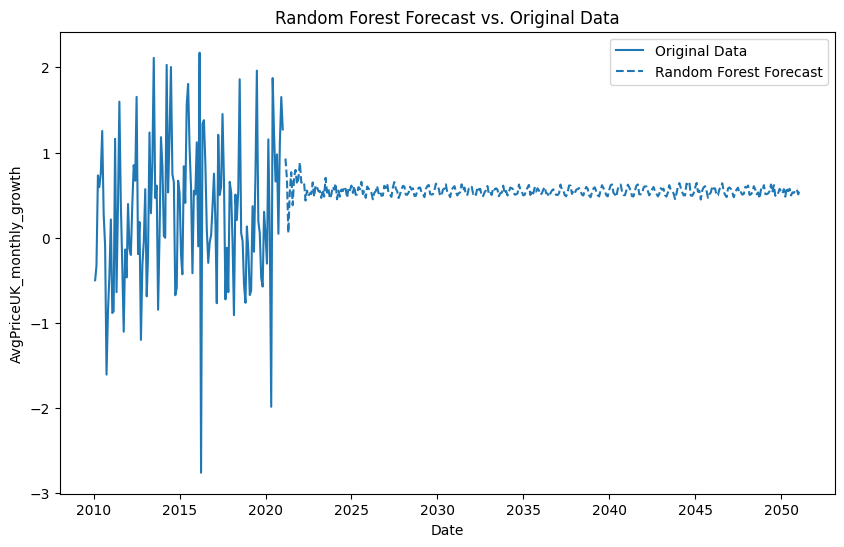

In [93]:
from sklearn.ensemble import RandomForestRegressor

# Choose the column to model
column_name = 'AvgPriceUK_monthly_growth'
data_series = data_df[column_name]

print("Data series shape:", data_series.shape)

# Normalize the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_series.values.reshape(-1, 1))

print("Data scaled shape:", data_scaled.shape)

# Create sequences for LSTM
sequence_length = 12
sequences = []
for i in range(len(data_scaled) - sequence_length + 1):
    sequences.append(data_scaled[i:i+sequence_length])

sequences = np.array(sequences)

print("Sequences shape:", sequences.shape)

# Split into training and forecasting data
training_size = len(sequences)  # Use all available data for training
train_data = sequences[:training_size]

print("Train data shape:", train_data.shape)

# Prepare training data
X_train = train_data[:, :-1]
y_train = train_data[:, -1]

# Reshape X_train to match Random Forest input shape
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

# Create and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

print("Random Forest model trained")

# Initialize an array to store forecasted values
forecasted_values = []

# Prepare forecast data
X_forecast = data_scaled[-sequence_length+1:].reshape(1, -1)  # Use the last available sequence for forecasting

print("X_forecast shape:", X_forecast.shape)

# Forecast using the trained model
for _ in range(360):  # Forecast for 30 years (12 months * 30)
    forecasted_value = rf_model.predict(X_forecast)
    forecasted_values.append(forecasted_value[0])

    # Update X_forecast with the new forecasted value
    X_forecast = np.roll(X_forecast, -1)
    X_forecast[0, -1] = forecasted_value

# Inverse transform the forecasted values
forecasted_values = scaler.inverse_transform(np.array(forecasted_values).reshape(-1, 1))

# Create date index for the forecasted values
forecast_dates = pd.date_range(start=data_series.index[-1] + pd.DateOffset(months=1), periods=len(forecasted_values), freq='M')

# Plot the original data and forecasted values
plt.figure(figsize=(10, 6))
plt.plot(data_series.index, data_series.values, label='Original Data')
plt.plot(forecast_dates, forecasted_values, color='#1f77b4', linestyle='--', label='Random Forest Forecast')
plt.xlabel('Date')
plt.ylabel('AvgPriceUK_monthly_growth')
plt.title('Random Forest Forecast vs. Original Data')
plt.legend()
plt.show()


#Model for just ashford (previous code)

In [ ]:
# Calculate the index for the end of 80% of the data
train_end_index = int(len(monthly_p_change_Ashford) * 0.8)
# Get the corresponding date for the training end point
train_end_date = monthly_avg_p_Ashford.index[train_end_index]
# Split the data into training and holdout sets
train_data = monthly_avg_p_Ashford[:train_end_date]
#  Create a date offset of one month to shift the train_end_date by one month so that
# we start the holdout period from the month after the last month of training data.
holdout_data = monthly_avg_p_Ashford[train_end_date + pd.DateOffset(months=1):]
# Train the SARIMA model on the training set
SARIMA_training_model = SARIMAX(train_data, order=(p, d, q), seasonal_order=(0, 0, 0, 6))
SARIMA_fit = SARIMA_training_model.fit(maxiter=1000)
# Generate the SARIMA forecast for the holdout period
holdout_forecast = SARIMA_fit.get_forecast(steps=len(holdout_data))
# Get the forecasted values
evaluation_forecasted_values = holdout_forecast.predicted_mean
# Get the actual values for the holdout period
actual_values = holdout_data
# Calculate Mean Absolute Error (MAE)
SARIMA_mae = mean_absolute_error(actual_values, evaluation_forecasted_values)
print(f"Mean Absolute Error (MAE): {SARIMA_mae:.2f}")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Mean Absolute Error (MAE): 75725.60


In [ ]:
#Training Data
# create training and tests sets
#training_data, testing_data = train_test_split(df_series, test_size = 0.2, random_state=42)
training_data = monthly_p_change_Ashford.sample(frac=0.8,random_state=42)
testing_data = monthly_p_change_Ashford.drop(training_data.index)
# set indexes for training and tests sets
index_train = pd.date_range("01/01/1995", "01/01/2010", freq="M")
index_test = pd.date_range("01/01/2011", "01/01/2022", freq="M")
# create series for forecasting variable
training_data=pd.Series(training_data, index=index_train)
testing_data=pd.Series(testing_data, index=index_test)

print('Number of training samples: {}, Number of testing samples: {}'.format(training_data.shape[0],testing_data.shape[0]))
print(training_data.shape)
print(index_train.shape)

# not sure whether these sould be NaN values but they are
#error below comes from here - why is there a NaN value?

Number of training samples: 180, Number of testing samples: 132
(180,)
(180,)


In [ ]:
# Training ARIMA model
#I chose a 80:20 (training:testing) split for training the data
def ARIMA_training_data(df_series,training_data):
  #Tried to do it a different way to you but it didnt work...
  #training_data, testing_data = train_test_split(df_series, test_size = 0.2, random_state=42)

  ARIMA_model_train = ARIMA(training_data,order=(3,0,1))
  ARIMA_fit_train = ARIMA_model_train.fit()
  ARIMA_forecast_train = ARIMA_fit_train.predict(start="2010", end="2022")[1:]
  ARIMA_forecast_train.plot(label="mean prediction", color='#1f77b4',linestyle="--")
  df_series.plot(label='Data')

ARIMA_training_data(monthly_p_change_Ashford,training_data)



NotImplementedError: ignored

                mean  pi_lower  pi_upper
2022-01-31  0.808605 -2.191659  3.808869
2022-02-28  0.774294 -2.228758  3.777346
2022-03-31  0.541272 -2.464566  3.547109
2022-04-30  0.805815 -2.202806  3.814437
2022-05-31  0.808718 -2.202698  3.820134
2022-06-30  0.774401 -2.239794  3.788596
2022-07-31  0.541374 -2.475599  3.558346
2022-08-31  0.805912 -2.213835  3.825660
2022-09-30  0.808810 -2.213723  3.831343
2022-10-31  0.774488 -2.250815  3.799792
2022-11-30  0.541457 -2.486616  3.569529
2022-12-31  0.805991 -2.224848  3.836830
2023-01-31  0.808885 -2.224731  3.842500
2023-02-28  0.774560 -2.261818  3.810937
2023-03-31  0.541524 -2.497613  3.580661
2023-04-30  0.806055 -2.235839  3.847950
2023-05-31  0.808946 -2.235716  3.853607
2023-06-30  0.774617 -2.272797  3.822032
2023-07-31  0.541579 -2.508586  3.591744
2023-08-31  0.806107 -2.246806  3.859021
2023-09-30  0.808995 -2.246677  3.864667
2023-10-31  0.774664 -2.283751  3.833080
2023-11-30  0.541624 -2.519533  3.602781
2023-12-31  0.80

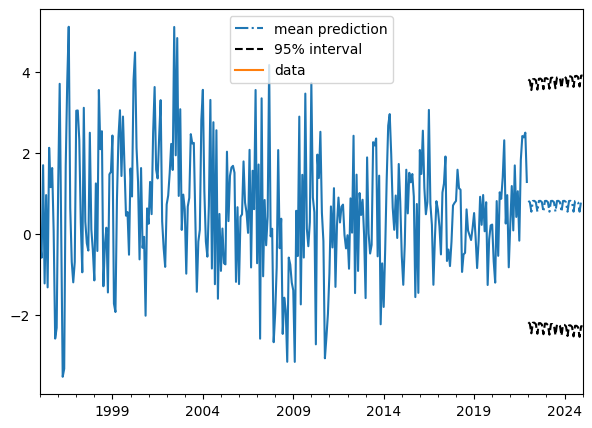

In [ ]:
#ETS model
#(make this into a function with input as monthly change series)
#run ETS AAA model, with damped trend and seasonal periods of 4
model_ETSforecast = ETSModel(
monthly_p_change_Ashford,
error="add",
trend="add",
seasonal="add",
damped_trend=True,
seasonal_periods=4,
)
# save model object
ETS_fit = model_ETSforecast.fit()
# run predictions
ETS_pred = ETS_fit.get_prediction(start="2022", end="2025")
# retreive predictions and confidence intervals with 95% confidence intervals (alpha=0.5)
df3 = ETS_pred.summary_frame(alpha=0.05)
print(df3)
# manually run simulations to produce confidence intervals
df3["mean"].plot(label="mean prediction", color='#1f77b4',linestyle="-.")
df3["pi_lower"].plot(linestyle="--", color="black", label="95% interval")
df3["pi_upper"].plot(linestyle="--", color="black", label="_")
monthly_p_change_Ashford.plot()
# label actual data and plot The endogenous/response variable
ETS_pred.endog.plot(label="data")
rcParams['figure.figsize']=7,5
# include legend
plt.legend()

In [ ]:
#ETS AAA Model Evaluation
model_ETSforecast_train = ETSModel(
training_data,error="add",
trend="add",
seasonal="add",
damped_trend=True,
seasonal_periods=4,).fit()

# run prediction
ETS_pred_train = model_ETSforecast_train.get_prediction(start="2010", end="2021")
# retreive predictions and confidence intervals with 95% confidence intervals (alpha=0.5)
df4 = ETS_pred_train.summary_frame(alpha=0.05)
df4['actual'] = testing_data.tolist()
df4["actual"].plot(linewidth = '3')
df4["mean"].plot(label="mean prediction", color='#1f77b4',linestyle="-.")
df4["pi_lower"].plot(linestyle="--", color="black", label="95% interval")
df4["pi_upper"].plot(linestyle="--", color="black", label="_")
plt.legend()


ValueError: ignored

In [ ]:
df3.shape

(37, 3)

ValueError: ignored

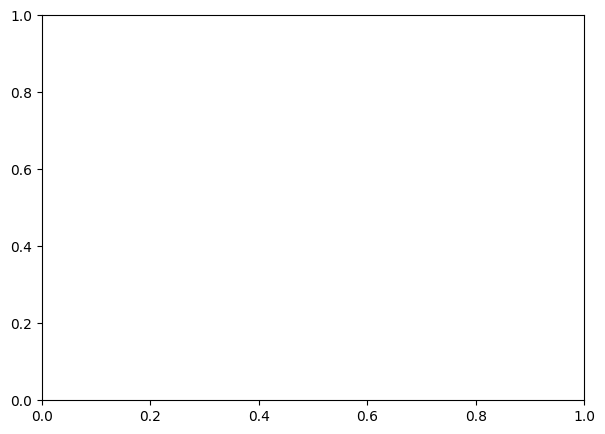

In [ ]:
# real predictive model
# should I be going back to the dataset and doing this with the actual prices instad of the %change? probably...
def plot_predictions(predictions,df,last_forecast_year):
  last_value = df.iat[-1]
  Dependent = df.values
  Y_pred_values = [] # Create list
  for predicted_growth in predictions:
    last_value = last_value*(1+predicted_growth/100)
    Y_pred_values.append(last_value)
  # Set the total data range and forecast range
  data_range = np.arange(1995,2022,1)
  forecast_range = np.arange(2023,last_forecast_year,1)
  total_range = np.concatenate([data_range,forecast_range])
  total_dependent = np.concatenate([Dependent,Y_pred_values])
  # Define plot space
  plt.plot(total_range, total_dependent)
  #plt.plot(total_range, A, color = "grey",linestyle="--" )
  # create A variable? (linear regression??)
  plt.xlabel("Year", fontsize=15)
  plt.ylabel("1%change Ashford", fontsize=15)
  plt.legend(['actual/forecast',"target"])
  # Set the Y axis to better reflect the
  plt.ylim([-4,6])
  # displaying the title
  plt.title("Housing price change in Ashford", fontsize=15)
  b1 = 2022
  b2 = 2052
  plt.axvspan(b1, b2, color='tab:olive', alpha=0.7)
  plt.show()






plot_predictions(df3["mean"],monthly_p_change_Ashford, 2052)

In [ ]:
# Evaluation metrics
#MSFE
# Make predictions on the test set
#arima_predictions = ARIMA_fit_train.predict(start=len(train_data), end=len(train_data) + len(testing_data) - 1)
sarima_predictions = SARIMA_fit.predict(start=len(train_data), end=len(train_data) + len(testing_data) - 1)
SARIMA_forecast = SARIMA_fit.get_forecast(steps=forecast_steps)

# Calculate MSFE for ARIMA model
#arima_msfe = mean_squared_error(testing_data['values'], arima_predictions)

# Calculate MSFE for SARIMA model
sarima_msfe = mean_squared_error(testing_data[actual_values], sarima_predictions)

#print("ARIMA MSFE:", arima_msfe)
print("SARIMA MSFE:", sarima_msfe)

NameError: ignored

Further work - label encoding for other variables to add into our predictive analysis